# USER MANUAL: How to use the simulator 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully in silico path to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated--create a sythesis SOLD matrix

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, mut_probs = [0.20, 0.20, 0.20, 0.20], parent_prob=0.20) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 
    

Parent protein: IHRQSTPIKMEAVCDQPRRDIQGEWDHWRVFYYNKSLHCNRTPHNEKVIELHHLLRYLIRHRPSWSMLVWKGRVHDSVDLAHENRKKKKHKMMHNEDDYH
Random mutaed positions [15 31 34 54 73]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

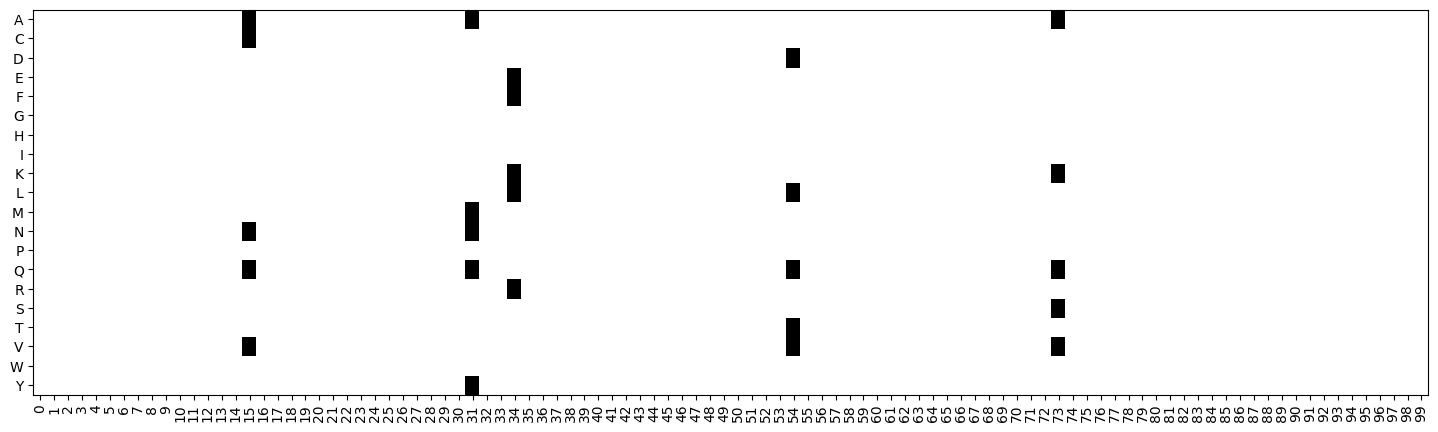

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 

Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentalist provided SOLD mat

In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)

In [5]:
seqs[0]

'VAEVS'

In [6]:
probs = S.compute_prob_n_mutations(num_mutated+1)

Text(0.5, 1.0, 'Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat')

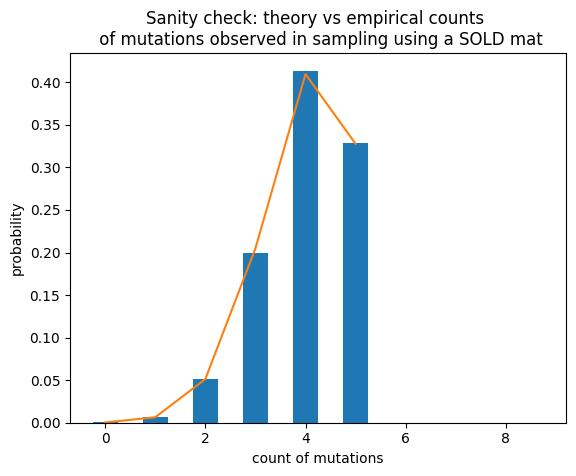

In [7]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Now I need to provide weights to the independent and pairwise contributions

I create a mixture of pdfs to draw from, with a zero component (meaning not all independent and pairwise contributions have differential activity compared to parent, some have no effect, and one can control this effect size or model complexity in these simulations) 
Create a mixture of weigthts with random components and some sparse components 

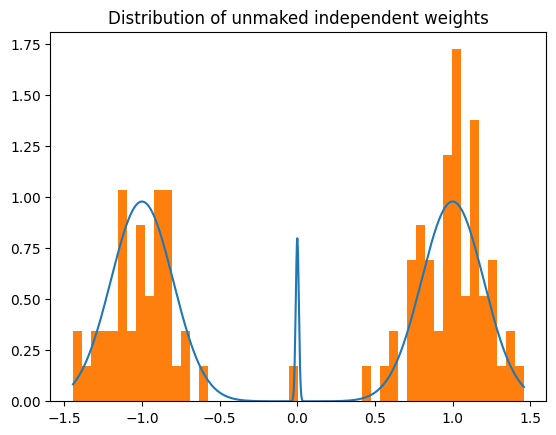

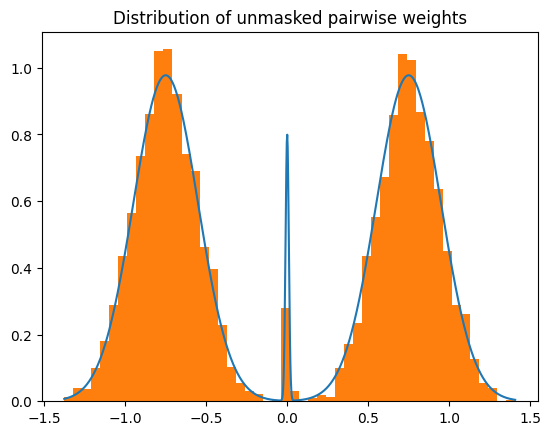

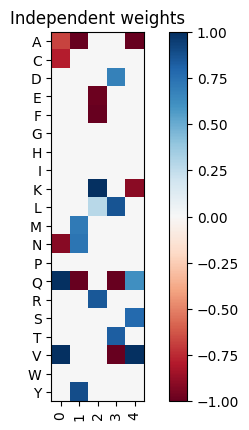

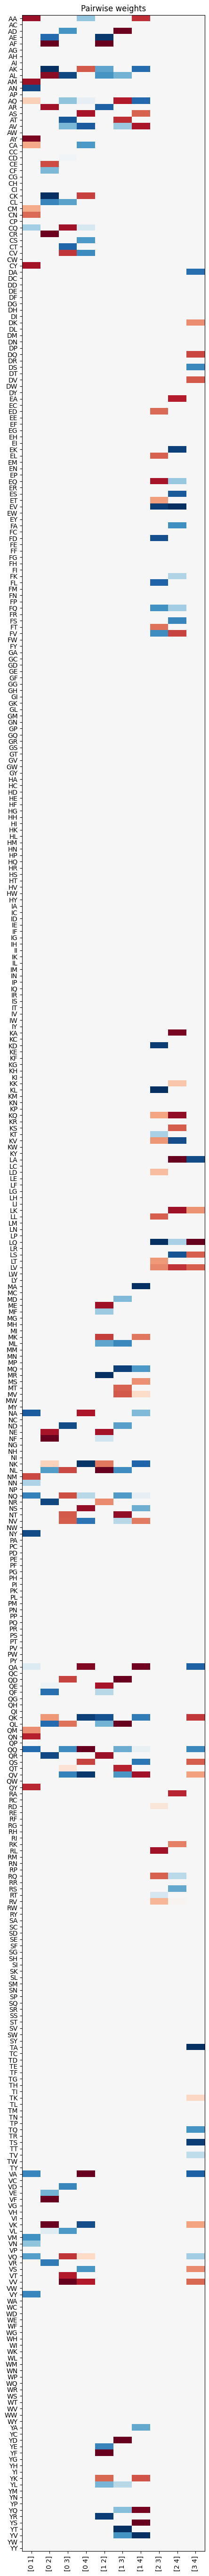

In [8]:
I_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
P_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 


Model_in_silico = doe_utils.create_in_silico_model(num_mutated, S.mutation_probs_variable_region_indexed, independent_params=I_params, pairwise_params=P_params)
Model_in_silico.plot_weights()

In [9]:
Model_in_silico.independent_params

{'rho': [0.49, 0.49],
 'sparse_pdf_names': ['norm', 'norm'],
 'noise_sigma': 0.01,
 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]}

# Now compute respose for a bunch of seqs

Need to eocnde the sequeces into pairwise and independent features 


# ENCODE

In [10]:
Encoder = doe_utils.sequence_encoder(num_mutated)
encodings = Encoder.encode_seqs(seqs) # this produces two lists --- the first 1 is the independent encodings, the second one is pairwise encodings 

In [11]:
responses = Model_in_silico.model(encodings[0], encodings[1], masked= True) 

Text(0.5, 1.0, 'in silico responses (indel activity)')

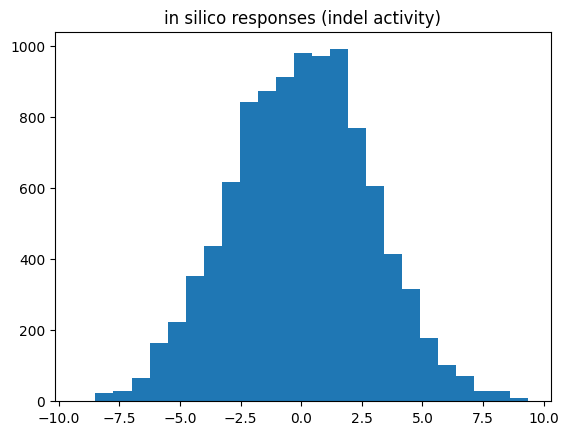

In [12]:
_ = plt.hist(responses, bins = 25)
plt.title("in silico responses (indel activity)") 

# Now do sparse (elastic net) linear regression to learn back the weights 

['0' '1']
[['0' 'A' '1' 'A']
 ['0' 'A' '1' 'M']
 ['0' 'A' '1' 'N']
 ['0' 'A' '1' 'Q']
 ['0' 'A' '1' 'Y']
 ['0' 'C' '1' 'A']
 ['0' 'C' '1' 'M']
 ['0' 'C' '1' 'N']
 ['0' 'C' '1' 'Q']
 ['0' 'C' '1' 'Y']
 ['0' 'N' '1' 'A']
 ['0' 'N' '1' 'M']
 ['0' 'N' '1' 'N']
 ['0' 'N' '1' 'Q']
 ['0' 'N' '1' 'Y']
 ['0' 'Q' '1' 'A']
 ['0' 'Q' '1' 'M']
 ['0' 'Q' '1' 'N']
 ['0' 'Q' '1' 'Q']
 ['0' 'Q' '1' 'Y']
 ['0' 'V' '1' 'A']
 ['0' 'V' '1' 'M']
 ['0' 'V' '1' 'N']
 ['0' 'V' '1' 'Q']
 ['0' 'V' '1' 'Y']]
['0' '2']
[['0' 'A' '2' 'E']
 ['0' 'A' '2' 'F']
 ['0' 'A' '2' 'K']
 ['0' 'A' '2' 'L']
 ['0' 'A' '2' 'R']
 ['0' 'C' '2' 'E']
 ['0' 'C' '2' 'F']
 ['0' 'C' '2' 'K']
 ['0' 'C' '2' 'L']
 ['0' 'C' '2' 'R']
 ['0' 'N' '2' 'E']
 ['0' 'N' '2' 'F']
 ['0' 'N' '2' 'K']
 ['0' 'N' '2' 'L']
 ['0' 'N' '2' 'R']
 ['0' 'Q' '2' 'E']
 ['0' 'Q' '2' 'F']
 ['0' 'Q' '2' 'K']
 ['0' 'Q' '2' 'L']
 ['0' 'Q' '2' 'R']
 ['0' 'V' '2' 'E']
 ['0' 'V' '2' 'F']
 ['0' 'V' '2' 'K']
 ['0' 'V' '2' 'L']
 ['0' 'V' '2' 'R']]
['0' '3']
[['0' 'A' '3' 'D']

Text(0, 0.5, 'fitted params')

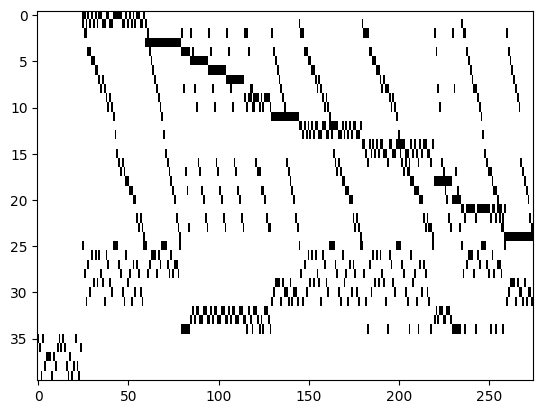

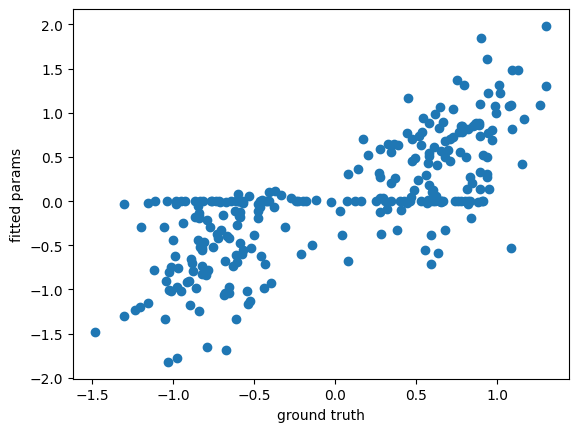

In [13]:
fit_model = doe_utils.fitting_model(S.mutation_probs_variable_region_indexed)
fitted_params, fit_responses = fit_model.fit(seqs, responses)

plt.figure() 
plt.imshow(fit_model.constraints, aspect = 'auto', cmap = 'Greys', interpolation = 'None') 
plt.figure() 
plt.scatter(Model_in_silico.ground_truth_params, fitted_params)
plt.xlabel("ground truth") 
plt.ylabel("fitted params") 



In [39]:
np.sum(Model_in_silico.pairwise_weights, axis =1)

array([-1.21110374,  0.        , -0.39183339,  1.74451032, -2.14053625,
        0.        ,  0.        ,  0.        ,  1.70216837,  1.07507421,
       -0.86382232,  0.90022985,  0.        ,  0.2308834 , -0.0248491 ,
       -1.41035651,  0.10835411,  0.8412313 ,  0.        , -0.9388861 ,
        0.19500366,  0.        ,  0.02814446, -0.65439677,  0.44624514,
        0.        ,  0.        ,  0.        ,  0.58244529,  1.20077094,
       -0.37288777, -0.56927747,  0.        , -0.33735919, -0.97940778,
        0.57659006,  0.7971114 , -0.07834371,  0.        , -0.83463827,
        0.75722993,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.46351047,  0.        ,
        0.        ,  0.        ,  0.        , -0.66561376,  0.        ,
        0.64493893,  0.        , -0.610663  ,  0.        ,  0.        ,
       -0.78330239,  0.        , -0.56993566,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.9372911 , -0.59

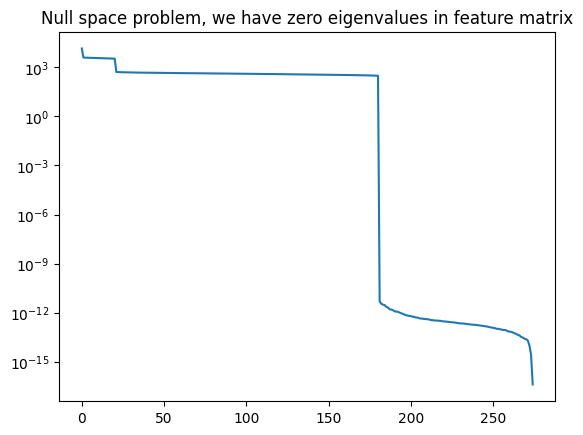

In [15]:
import scipy 

plt.plot(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)))

plt.title('Null space problem, we have zero eigenvalues in feature matrix')
plt.yscale('log')

Text(0.5, 1.0, 'Pairwise params')

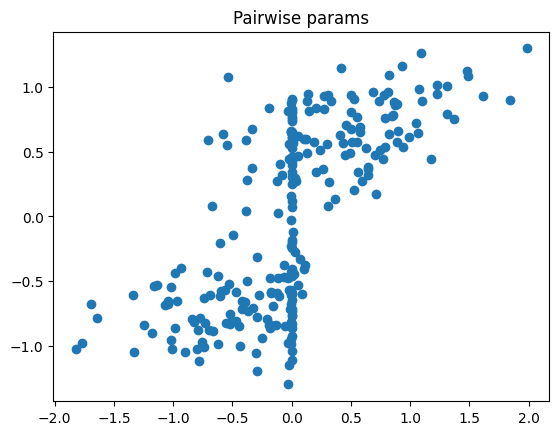

In [16]:
plt.scatter(fitted_params[fit_model.pairwise_indices], Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask])
plt.title('Pairwise params') 

In [17]:
a,b  = doe_utils._create_zero_mean_pairwise_weights(Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)
c,d = doe_utils._create_zero_mean_pairwise_weights(fitted_params[fit_model.pairwise_indices], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

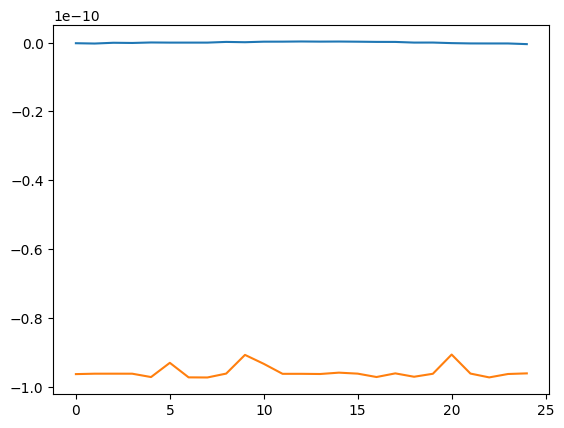

In [18]:
plt.plot(b)
plt.plot(d)

In [37]:
d

array([-9.63076618e-11, -9.61883459e-11, -9.61846353e-11, -9.61905361e-11,
       -9.71631844e-11, -9.30304056e-11, -9.72550540e-11, -9.72867176e-11,
       -9.61579510e-11, -9.07262051e-11, -9.33230826e-11, -9.62269407e-11,
       -9.62241245e-11, -9.62778182e-11, -9.58839119e-11, -9.61730084e-11,
       -9.71539910e-11, -9.60950097e-11, -9.70751812e-11, -9.62116026e-11,
       -9.06285880e-11, -9.61512292e-11, -9.72641738e-11, -9.62758040e-11,
       -9.60963453e-11])

Text(0.5, 1.0, 'independent params')

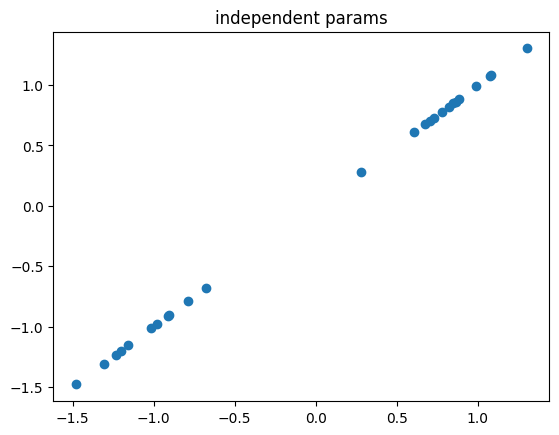

In [19]:
plt.scatter(fitted_params[fit_model.independent_indices], Model_in_silico.independent_weights[Model_in_silico.independent_mask])
plt.title('independent params')

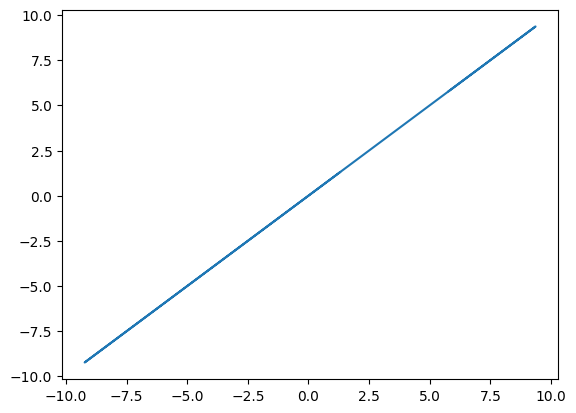

In [20]:
plt.plot(fit_responses, responses)

In [21]:
np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001)

np.int64(94)

In [22]:
print("Cant account for ... ") 

np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001) -np.shape(fit_model.constraints)[0]

Cant account for ... 


np.int64(54)

In [23]:
np.shape(Model_in_silico.pairwise_weights)

(400, 10)

In [24]:
np.shape(fit_model.constraints)

(40, 275)

In [25]:
np.shape(fit_model.independent_indices)

(25,)

In [26]:
np.shape(fit_model.pairwise_indices)

(250,)

In [27]:
import re

A = np.asarray([re.split(':' + "|" + '-', a) for a in Model_in_silico.feature_names_pairwise]) 

collector = [] 
for a in A: 
    if a[1] != a[3]:
        collector.append(a)
    

In [28]:
np.shape(fit_model.independent_indices)

(25,)

In [29]:
ij = [a+b for a,b in zip(A[:,1],A[:,3])]
len(np.unique(ij))

142

In [30]:
np.unique([[a,b] for a,b in zip(A[:,0], A[:,2])], axis = 0)

array([['0', '1'],
       ['0', '2'],
       ['0', '3'],
       ['0', '4'],
       ['1', '2'],
       ['1', '3'],
       ['1', '4'],
       ['2', '3'],
       ['2', '4'],
       ['3', '4']], dtype='<U1')

In [31]:
A[:, [0, 2]]

array([['0', '1'],
       ['0', '4'],
       ['1', '4'],
       ['0', '3'],
       ['1', '3'],
       ['0', '2'],
       ['1', '2'],
       ['0', '2'],
       ['1', '2'],
       ['0', '2'],
       ['0', '4'],
       ['1', '2'],
       ['1', '4'],
       ['0', '2'],
       ['0', '3'],
       ['1', '2'],
       ['1', '3'],
       ['0', '1'],
       ['0', '1'],
       ['0', '1'],
       ['0', '3'],
       ['0', '4'],
       ['1', '3'],
       ['1', '4'],
       ['0', '2'],
       ['1', '2'],
       ['0', '4'],
       ['1', '4'],
       ['0', '3'],
       ['1', '3'],
       ['0', '3'],
       ['0', '4'],
       ['1', '3'],
       ['1', '4'],
       ['0', '1'],
       ['0', '1'],
       ['0', '4'],
       ['0', '3'],
       ['0', '2'],
       ['0', '2'],
       ['0', '2'],
       ['0', '4'],
       ['0', '2'],
       ['0', '3'],
       ['0', '1'],
       ['0', '1'],
       ['0', '1'],
       ['0', '3'],
       ['0', '4'],
       ['0', '2'],
       ['0', '4'],
       ['0', '3'],
       ['0',

In [32]:
inds = np.all(A[:, [0,2]] == ['0', '1'], axis = 1)
inds

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [33]:
A[inds]

array([['0', 'A', '1', 'A'],
       ['0', 'A', '1', 'M'],
       ['0', 'A', '1', 'N'],
       ['0', 'A', '1', 'Q'],
       ['0', 'A', '1', 'Y'],
       ['0', 'C', '1', 'A'],
       ['0', 'C', '1', 'M'],
       ['0', 'C', '1', 'N'],
       ['0', 'C', '1', 'Q'],
       ['0', 'C', '1', 'Y'],
       ['0', 'N', '1', 'A'],
       ['0', 'N', '1', 'M'],
       ['0', 'N', '1', 'N'],
       ['0', 'N', '1', 'Q'],
       ['0', 'N', '1', 'Y'],
       ['0', 'Q', '1', 'A'],
       ['0', 'Q', '1', 'M'],
       ['0', 'Q', '1', 'N'],
       ['0', 'Q', '1', 'Q'],
       ['0', 'Q', '1', 'Y'],
       ['0', 'V', '1', 'A'],
       ['0', 'V', '1', 'M'],
       ['0', 'V', '1', 'N'],
       ['0', 'V', '1', 'Q'],
       ['0', 'V', '1', 'Y']], dtype='<U1')

Text(0.5, 1.0, 'VAEVS')

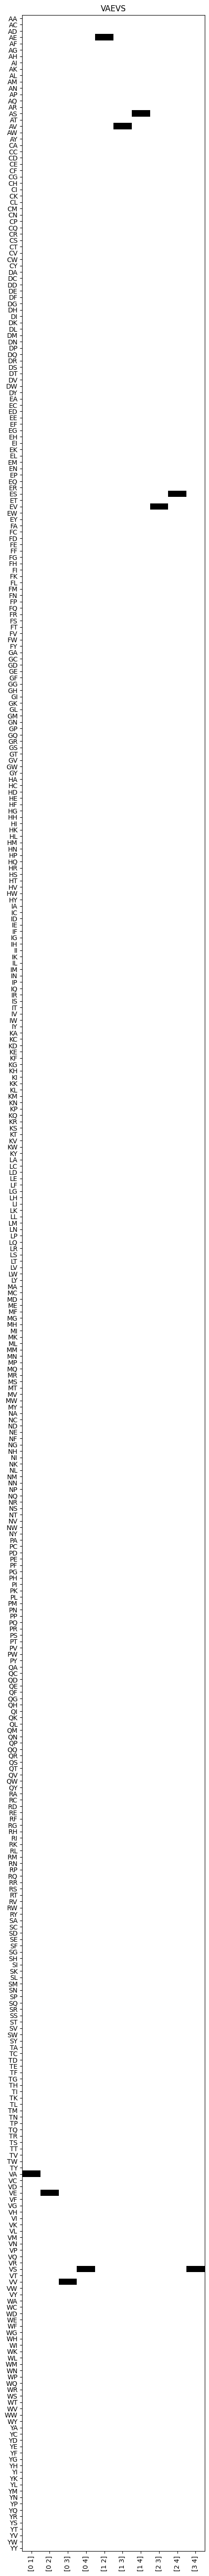

In [34]:

plt.figure(figsize = (5, 70))
plt.imshow(encodings[1][0], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 1, cmap = 'Greys')
_  = plt.xticks(range(len(Encoder.pos_product)), Encoder.pos_product, rotation = 90)
_  = plt.yticks(range(len(Encoder.amino_product)), Encoder.amino_product)
plt.title(seqs[0]) 

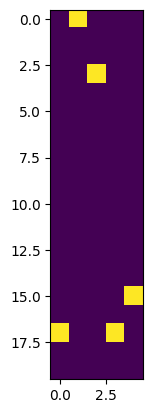

In [35]:
plt.imshow(encodings[0][0])

In [36]:
np.max([1,2,3])

np.int64(3)